This notbook is inspired on Andrej Karpathy's youtube lecture about micrograd. Available on https://www.youtube.com/watch?v=VMj-3S1tku0&t=5128s 

In [25]:
import math
import numpy as np 
import matplotlib.pyplot as plt

In [26]:
def f(x):
    return 3*x**2 -4*x + 5

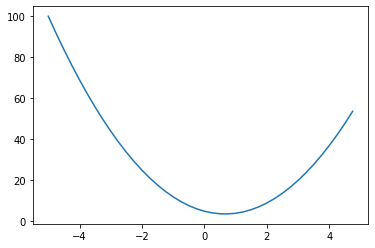

In [27]:
xs = np.arange (-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [28]:
h = 0.001
x = 3

In [29]:
# As it is excruciating to calculate the real derivative of a neural network, we go By the definition of derivative:
# f' = (f(x+h)-f(x))/h
# So the slope at point x is the following
(f(x+h)-f(x))/h

14.00300000000243

In [30]:
# Getting more complex and similar to neurons in neural networks
h=0.001
a = 2
b = -3
c = 10

d1 = a*b + c
a+=h
d2 = a*b+c
print('d1: ',d1)
print('d2: ',d2)
print('slope: ',(d2-d1)/h)

d1:  4
d2:  3.997
slope:  -3.0000000000001137


In [95]:
# This is a data structre that will maintain these expressions in neural newtworks with its expressions
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) # Children are supposed to be tuples. _prev represents the previous value before the last operation
        self.grad = 0 # The derivative, which starts at 0. As a derivative of 0 means that there is no change
        self._op = _op # Operation symbol
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        # Defining these operators with these __xxx__
        out = Value(self.data +other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad # It's a 1 as this is a plus operation
            other.grad += 1 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # Chain rule
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad # Chain rule
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set() # visited nodes
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev: # iterates through all the children of the node
                    build_topo(child)
                topo.append(v) # It only adds the node itself after going through all the children

        build_topo(self)

        self.grad = 1
        #This makes what we did manually goes from O to the beginning
        for node in reversed(topo):
            node._backward()    

In [64]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data = -8.0)

In [33]:
d._prev, d._op

({Value(data = -6.0), Value(data = 10.0)}, '+')

In [62]:
import graphviz 
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [35]:
# function to measure the differences the h makes to see the derivatives
def lol():
    h=0.000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-2.000000000279556


L = d*f

dL/dd = ?

(f(x+h)-f(x))/h - definition of derivative

Proof of what is the grad of d taking L into account by the definition of derivative

((d+h) * f -d * f)/h 

(d * f + h*f - d * f)/h

(h * f)/h

f


In [36]:
f.grad = 4
d.grad = -2

How does C impact L. It is through d
C impacts d which impacts L 

dL/dc = ?

dd/dc = ?

d = c+e

dd/dc = 1

Want: dL/dc

Know: dd/dc

Chain rule of derivatives: dz/fx = dz/dy * dy/dx

dL/dc = dL/dd * dd/dc

dL/dc = f * 1

dL/dc = f





In [37]:
c.grad = -2
e.grad = -2

dL/da = ?

dL/da = (dL/de) * (de/da)

As e = a * b

de/da = b

dL/da = -2 * b

dL/db = ?

dL/db = dL/de * de/db

dL/db = -2 * a

In [38]:
a.grad = -2 * -3
b.grad = -2 * 2

The application of backpropagation is just the chain of rule in calculus. We calculate the local derivatives and recursively multiply on the local derivatives

In [39]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

# We expect it to go up
print(L.data)

-7.286496


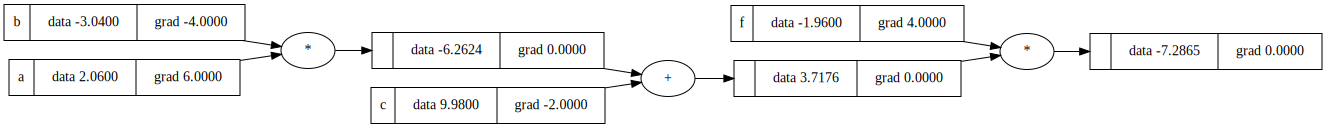

In [40]:
draw_dot(L)

Now we want to backpropagate in a neuron

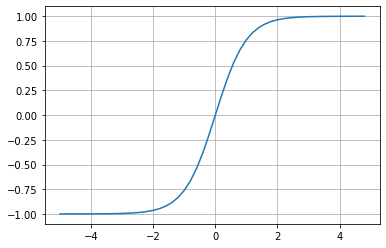

In [41]:
# Tanh activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [84]:
# inputs x1,x2. Two inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2. Weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# Basically it all ads up to x1*w1 + x2*w2 + b, it's just divided in steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1*x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

What really matters is the derivative of the weights

In [77]:
o.grad =1 

if o = tanh()

d0/dn = 1- tanh(n)**2

In [45]:
1-o.data**2

0.4999999999999999

In [78]:
n.grad = 0.5

In [79]:
# As both condtribute equally due to the +. n = b + x1w1x2w2
# dn/dx1w1x2w2 = 1
# dn/db = 1 
# do/dn * dn/db = 0.5*1 = 0.5
# do/dx1w1x2w2 = do/dn * dn/ddx1w1x2w2 = 0.5*1 = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [80]:
# Similarly to the above cell
x1w1.grad = 0.5
x2w2.grad = 0.5

In [81]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

To end all of this manual operations now we implement the backward function in the value class

In [86]:
o.grad = 1
# Calculate the grad of the previous elements
o._backward()

In [87]:
n._backward()

In [88]:
x1w1x2w2._backward()

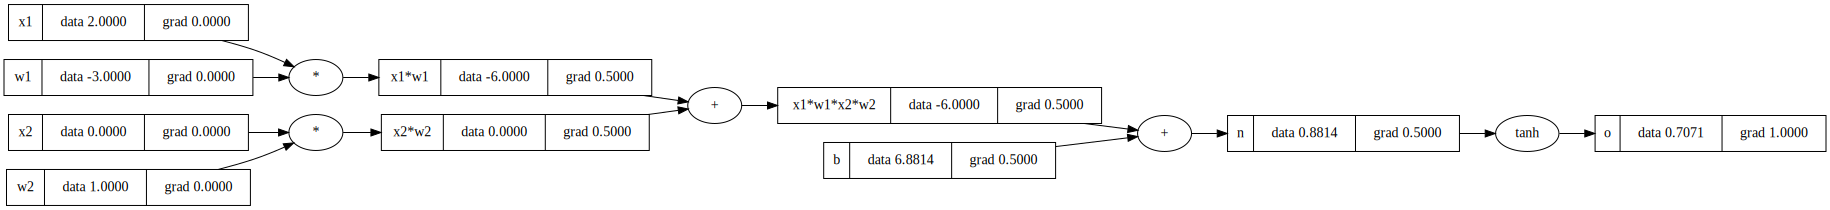

In [89]:
draw_dot(o)

Topological sort graph

In [90]:
#This basically makes the graph going from left to right and never the other way aroun
topo = []
visited = set() # visited nodes
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev: # iterates through all the children of the node
      build_topo(child)
    topo.append(v) # It only adds the node itself after going through all the children

build_topo(o)
topo

[Value(data = 0.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = -3.0),
 Value(data = 2.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [ ]:
topo = []
visited = set() # visited nodes
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev: # iterates through all the children of the node
      build_topo(child)
    topo.append(v) # It only adds the node itself after going through all the children

build_topo(o)
topo

# This makes what we did manually goes from o to the beginning, calculating all the gradients
for node in reversed(topo):
  node._backward()

We have a problem where if you use the same variable more than once you will be overwriting the self with the other.

The trick is to instead of defining them as equalities:

def _backward():
            self.grad = other.data * out.grad # Chain rule
            other.grad = self.data * out.grad
        out._backward = _backward

we should define them as accumulations, plus equals

def _backward():
            self.grad += other.data * out.grad # Chain rule
            other.grad += self.data * out.grad
        out._backward = _backward

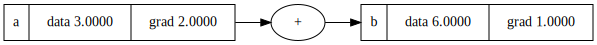

In [96]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

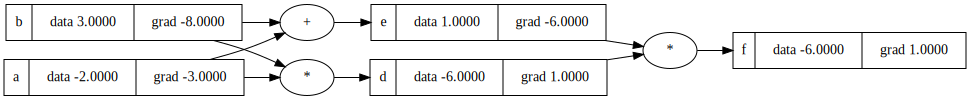

In [97]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)